# Übung 4: Supportvektormaschinen mit SciKit Learn, Random Forests und Boosting

## 1. Klassifikation mit SVMs

In [269]:
%matplotlib inline
import random
import time
import pandas as pd
import numpy as np
import seaborn as sns
import sklearn
from sklearn import linear_model
from sklearn.metrics import classification_report
from sklearn.datasets import load_digits
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
import skimage as ski
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from mpl_toolkits import mplot3d

np.set_printoptions(suppress=True, linewidth=np.inf)
sns.set_style("darkgrid")

%reload_ext version_information
%version_information numpy, pandas, seaborn, sklearn, skimage, random, matplotlib, mpl_toolkits

Software,Version
Python,3.7.4 64bit [GCC 7.3.0]
IPython,7.8.0
OS,Linux 4.15.0 70 generic x86_64 with debian buster sid
numpy,1.17.2
pandas,0.25.1
seaborn,0.9.0
sklearn,0.21.3
skimage,0.15.0
random,The 'random' distribution was not found and is required by the application
matplotlib,3.1.1


### a) Einlesen, Vorverarbeiten und Anzeigen der Daten

/home/henning/anaconda3/envs/base_mldl/lib/python3.7/site-packages/skimage/io/_plugins/matplotlib_plugin.py:75: UserWarning: Low image data range; displaying image with stretched contrast.
  warn("Low image data range; displaying image with "


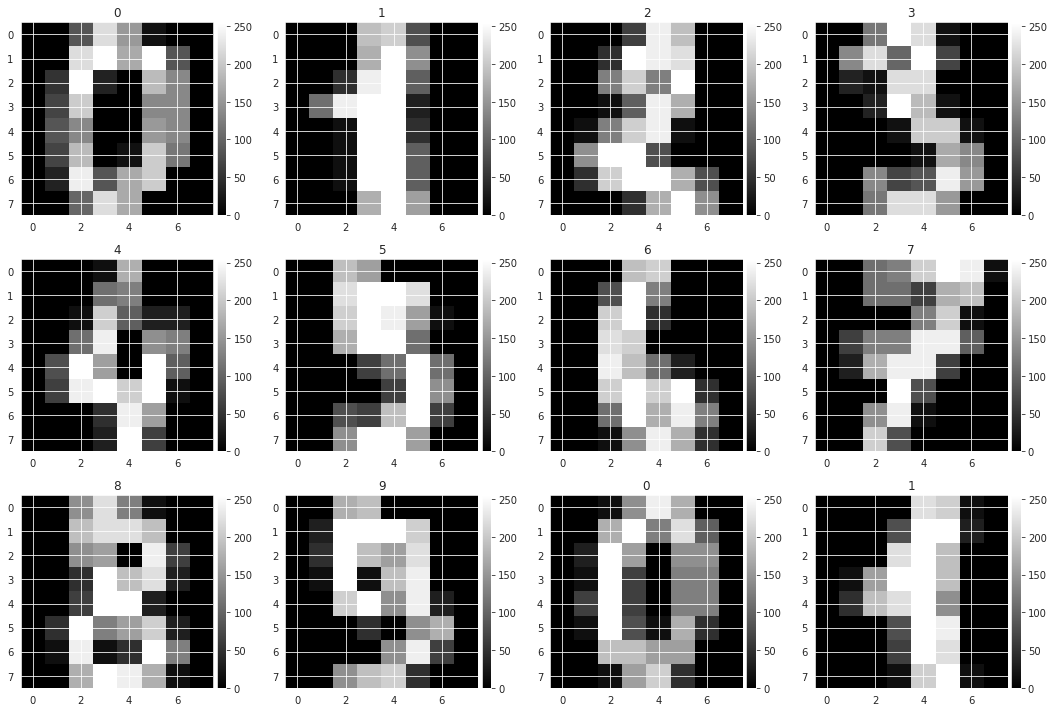

In [122]:
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt

digits = load_digits()
data = digits.data
labels = digits.target
n, d = data.shape

ncols, nrows = 4, 3
fig = plt.figure(figsize=(15,10))
spec = gridspec.GridSpec(ncols=ncols, nrows=nrows, figure=fig)
for i in range(nrows):
    for j in range(ncols):
        ax = fig.add_subplot(spec[i, j])
        ax.set_title(labels[i * ncols + j])
        img = (data[i * ncols + j]*(255/data[i * ncols + j].max())).astype(int)
        ski.io.imshow(img.reshape(8,8), ax=ax, cmap="gray")

### b) Mit SVM-Klassifikator arbeiten

In [123]:
def shuffle(data, labels):
    mixer = list(zip(data, labels))
    random.shuffle(mixer)
    data, labels = zip(*mixer)
    return data, labels

In [124]:
def sample_data(n_test, data, labels):
    data = np.asarray(data)
    n, d = data.shape
    n_train = n - n_test
    train_data = data[:n_train]
    test_data = data[n_train:]
    train_labels = labels[:n_train]
    test_labels = labels[n_train:]
    return train_data, test_data, train_labels, test_labels

In [125]:
def train_svm(train_data, train_labels, test_data, test_labels, C, gamma, precision=4, printout=False):
    svm = SVC(C=C, gamma=gamma)
    svm.fit(train_data, train_labels)
    train_score = np.round(svm.score(train_data, train_labels), precision)
    test_score = np.round(svm.score(test_data, test_labels), precision)

    if printout:
        if train_score < test_score:
            print("Underfitting! Train score is smaller then test score. train: {}, test: {}".format(train_score, test_score))
        elif train_score > test_score:
            print("Overfitting! Train score is higher then test score. train: {}, test: {}".format(train_score, test_score))
        else:
            print("Perfect! Train score is equal to the test score. train: {}, test: {}".format(train_score, test_score))   
    
    return train_score, test_score

In [126]:
data, labels = shuffle(data, labels)
n_test = int(n * 0.5)
n_train = n - n_test
train_data, test_data, train_labels, test_labels = sample_data(n_test, data, labels)

C = 1.0
gamma = 0.015
train_svm(train_data, train_labels, test_data, test_labels, C, gamma, printout=True)
    
C = 100
gamma = 0.001
_, _ = train_svm(train_data, train_labels, test_data, test_labels, C, gamma, printout=True)

Overfitting! Train score is higher then test score. train: 1.0, test: 0.2617
Overfitting! Train score is higher then test score. train: 1.0, test: 0.9944


## 2. Kreuzvalidierung und Modellselektion

### a) SVM mit verschiedenen Splits

In [127]:
C = 100
gamma = 0.001
for i in range(3):
    data, labels = shuffle(data, labels)
    train_data, test_data, train_labels, test_labels = sample_data(int(n * 0.25), data, labels)
    train_svm(train_data, train_labels, test_data, test_labels, C, gamma, printout=True)

Overfitting! Train score is higher then test score. train: 1.0, test: 0.9889
Overfitting! Train score is higher then test score. train: 1.0, test: 0.9911
Overfitting! Train score is higher then test score. train: 1.0, test: 0.9933


### b) Kreuzvalidierung mit SciKit-Methode

In [128]:
C = 100
gamma = 0.001
svm = SVC(C=C, gamma=gamma)
scores = cross_val_score(svm, train_data, train_labels, cv=10)
mean = np.mean(scores)
std = np.std(scores)
print(scores)
print("mean: {}, std: {}".format(mean, std))

[0.99275362 0.98550725 0.99264706 0.99264706 0.98529412 0.98507463 0.98507463 0.9924812  1.         0.99236641]
mean: 0.9903845973811938, std: 0.004719344976063393


### c) GridSearch von "Hand"

In [129]:
n_small = 500
data_small = data[:n_small]
labels_small = labels[:n_small]

n_Cs = 1
min_C, max_C = 10, 10
Cs = np.linspace(min_C, max_C, n_Cs)

n_gammas = 10
min_gamma, max_gamma = -7, -1
gammas = np.logspace(min_gamma,  max_gamma, n_gammas)

n_test = int(n_small * 0.5)
n_splits = 5

plot_data_train = np.zeros(shape=(n_gammas, n_Cs), dtype=np.float)
plot_data_test = np.zeros(shape=(n_gammas, n_Cs), dtype=np.float)

max_mean, max_gamma, max_C = 0.0, 0.0, 0.0
for i, gamma in enumerate(gammas):
    for j, C in enumerate(Cs):
        scores_train = 0.0
        scores_test = 0.0
        for _ in range(n_splits):
            data_small, labels_small = shuffle(data_small, labels_small)
            train_data, test_data, train_labels, test_labels = sample_data(n_test, data_small, labels_small)
            train_score, test_score = train_svm(train_data, train_labels, test_data, test_labels, C, gamma)
            scores_train += train_score
            scores_test += test_score
        mean_test = (scores_test/n_splits)
        plot_data_train[i, j] = (scores_train/n_splits)
        plot_data_test[i, j] = mean_test
        
        if mean_test > max_mean:
            max_mean = mean_test
            max_gamma = gamma
            max_C = C
print("Best parameters: (C: {}, gamma: {})".format(max_C, max_gamma))
print("Best score: {}".format(max_mean))

Best parameters: (C: 10.0, gamma: 0.001)
Best score: 0.9736


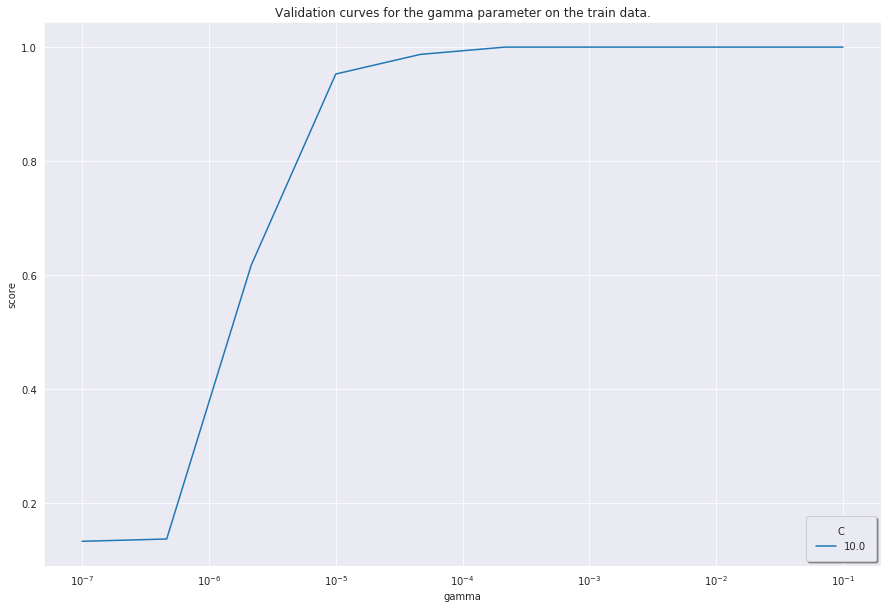

In [130]:
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(15, 10))
for i, C in enumerate(Cs):
    ax = sns.lineplot(x=gammas, y=plot_data_train[:, i], label=C)
    ax.set(xscale="log")
    ax.set_title('Validation curves for the gamma parameter on the train data.');
    ax.set_xlabel("gamma")
    ax.set_ylabel("score")
    ax.legend(loc="lower right", fancybox=True, framealpha=1, shadow=True, borderpad=1, title="C")

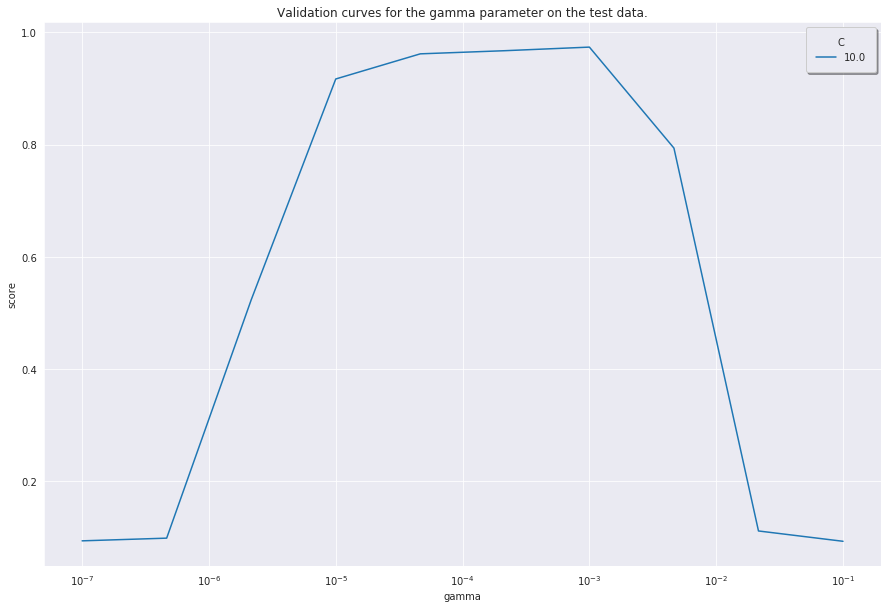

In [131]:
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(15, 10))
for i, C in enumerate(Cs):
    ax = sns.lineplot(x=gammas, y=plot_data_test[:, i], label=C)
    ax.set(xscale="log")
    ax.set_title('Validation curves for the gamma parameter on the test data.');
    ax.set_xlabel("gamma")
    ax.set_ylabel("score")
    ax.legend(loc="upper right", fancybox=True, framealpha=1, shadow=True, borderpad=1, title="C")

In [132]:
%matplotlib notebook
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d

fig = plt.figure()
ax = plt.axes(projection='3d')
X, Y = np.meshgrid(gammas, Cs)
ax.plot_surface(X, Y, plot_data_test, rstride=1, cstride=1,cmap='viridis', edgecolor='none')
ax.set_title('surface')
ax.set_xlabel("gamma")
ax.set_ylabel("C")
ax.set_zlabel("score")

### d) GridSearch mit SciKit

In [201]:
n_small = 500
data_small = data[:n_small]
labels_small = labels[:n_small]

n_Cs = 4
min_C, max_C = -1, 2
Cs = np.logspace(min_C, max_C, n_Cs)

n_gammas = 5
min_gamma, max_gamma = -4, 0
gammas = np.logspace(min_gamma,  max_gamma, n_gammas)

n_test = int(n_small * 0.5)
n_splits = 3

train_data, test_data, train_labels, test_labels = sample_data(n_test, data_small, labels_small)

svc_params = {'C': Cs,'gamma': gammas}
gridsvm = sklearn.model_selection.GridSearchCV(SVC(), param_grid=svc_params, cv=n_splits)
gridsvm.fit(train_data, train_labels)
y_true, y_pred = test_labels, gridsvm.predict(test_data)

print(f"Best parameters: {gridsvm.best_params_}")
print(f"Best score: {gridsvm.best_score_}")
print()
print("Classification report:")
print(classification_report(y_true, y_pred))

Best parameters: {'C': 10.0, 'gamma': 0.001}
Best score: 0.952

Classification report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        38
           1       0.91      1.00      0.95        21
           2       1.00      1.00      1.00        24
           3       1.00      0.94      0.97        16
           4       1.00      1.00      1.00        30
           5       0.96      1.00      0.98        23
           6       1.00      1.00      1.00        17
           7       0.91      1.00      0.95        21
           8       1.00      0.94      0.97        32
           9       1.00      0.93      0.96        28

    accuracy                           0.98       250
   macro avg       0.98      0.98      0.98       250
weighted avg       0.98      0.98      0.98       250

64


/home/henning/anaconda3/envs/base_mldl/lib/python3.7/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


## 3. Klassifikation mit Random Forests und Boosting

### a) Klassifikator mit Random Forest

In [214]:
n_iterations = 100
n_estimators = 100
max_depth = 8

oob_errors = []
error_rates = []

for i in range(n_iterations):
    n_small = 500
    data_small = data[:n_small]
    labels_small = labels[:n_small]

    data, labels = shuffle(data, labels)
    n_test = int(n_small * 0.5)
    train_data, test_data, train_labels, test_labels = sample_data(n_test, data, labels)

    rndf = RandomForestClassifier(n_estimators, max_depth=max_depth, random_state=0, oob_score=True)
    rndf.fit(train_data, train_labels)
    y_true, y_pred = test_labels, rndf.predict(test_data)
    best_score = rndf.score(test_data, test_labels)
    error_rate = 1 - best_score
    oob_error = 1 - rndf.oob_score_
    oob_errors.append(oob_error)
    error_rates.append(error_rate)

In [215]:
print(f"Best score: {best_score}, error_rate: {error_rate}, out-of-bag error: {oob_error}")
print()
print("Classification report:")
print(classification_report(y_true, y_pred))

Best score: 0.964, error_rate: 0.03600000000000003, out-of-bag error: 0.03361344537815125

Classification report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        25
           1       0.90      1.00      0.95        19
           2       1.00      1.00      1.00        22
           3       1.00      0.96      0.98        23
           4       1.00      0.96      0.98        23
           5       0.93      0.97      0.95        29
           6       1.00      0.96      0.98        26
           7       0.91      1.00      0.95        21
           8       0.94      0.97      0.96        33
           9       0.96      0.86      0.91        29

    accuracy                           0.96       250
   macro avg       0.97      0.97      0.97       250
weighted avg       0.97      0.96      0.96       250



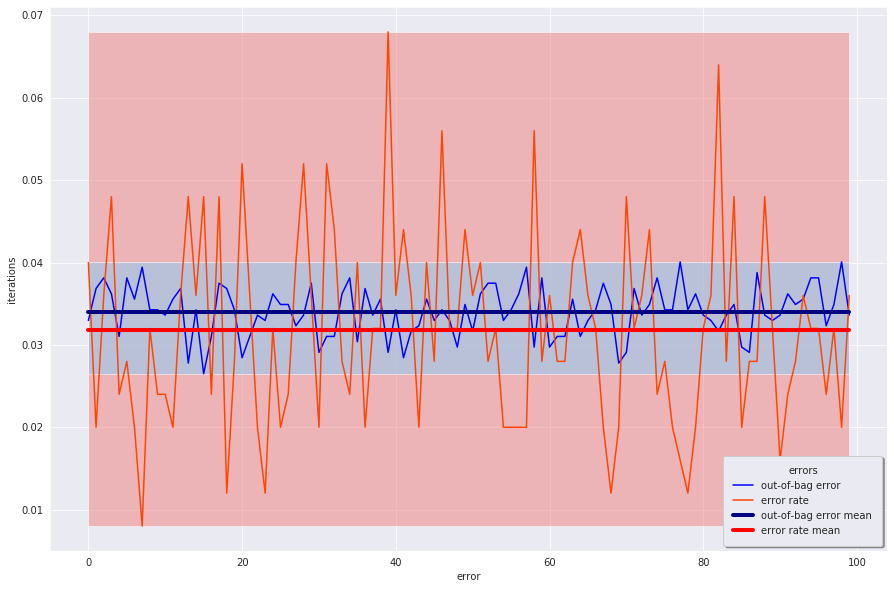

In [216]:
fig = plt.figure(figsize=(15, 10))
x = np.arange(0, n_iterations, 1)

obb_mean = np.mean(oob_errors)
error_rate_mean = np.mean(error_rates)
obb_error_min, obb_error_max = min(oob_errors), max(oob_errors)
error_rate_min, error_rate_max = min(error_rates), max(error_rates)

ax = sns.lineplot(x, y=oob_errors, label='out-of-bag error', color='blue')
ax = sns.lineplot(x, y=error_rates, label='error rate', color='orangered')

ax = sns.lineplot(x, y=obb_mean, label='out-of-bag error mean', color='navy', linewidth=4)
ax = sns.lineplot(x, y=error_rate_mean, label='error rate mean', color='red', linewidth=4)

ax.fill_between(x, error_rate_min, error_rate_max, facecolor='lightcoral', alpha=0.5)
ax.fill_between(x, obb_error_min, obb_error_max, facecolor='lightskyblue', alpha=0.5)

ax.set_xlabel("error")
ax.set_ylabel("iterations")
ax.legend(loc="lower right", fancybox=True, framealpha=1, shadow=True, borderpad=1, title="errors")

#### - Der out-of-bag error bleibt bei mehrfacher Ausführung konstant. 
#### - Die Fehlerrate schwankt stärker. 
#### - Der out-of-bag error  error ist im Mittelwert höher als die Fehlerrate.

### b) Random Forest mit Boosting

In [261]:
n_estimators = 100
max_depth = 8

boost = GradientBoostingClassifier(n_estimators=n_estimators, max_depth=max_depth, random_state=0)
boost.fit(train_data, train_labels)
best_score = boost.score(test_data, test_labels)
error_rate = 1 - best_score

print(f"Best score: {best_score}")
print()
print("Classification report:")
print(classification_report(y_true, y_pred))

Best score: 0.92

Classification report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        25
           1       0.90      1.00      0.95        19
           2       1.00      1.00      1.00        22
           3       1.00      0.96      0.98        23
           4       1.00      0.96      0.98        23
           5       0.93      0.97      0.95        29
           6       1.00      0.96      0.98        26
           7       0.91      1.00      0.95        21
           8       0.94      0.97      0.96        33
           9       0.96      0.86      0.91        29

    accuracy                           0.96       250
   macro avg       0.97      0.97      0.97       250
weighted avg       0.97      0.96      0.96       250



### OPTIONAL: GridSearch für Random Forest mit Boosting 

In [271]:
estimators = np.arange(10, 450, 10)
depths = np.arange(1, 9, 1)

n_ = len(estimators)
d_ = len(depths)

print("Number of trees: {}".format(estimators))
print("Number of depths: {}".format(depths))

min_error = np.inf
min_params = None
errors = np.zeros(shape=(d_, n_))

start = time.time()
for i, max_depth in enumerate(depths):
    for j, n_estimators in enumerate(estimators):
        boost = GradientBoostingClassifier(n_estimators=n_estimators, max_depth=max_depth, random_state=0)
        boost.fit(train_data, train_labels)
        best_score = boost.score(test_data, test_labels)
        error = 1 - best_score
        
        errors[i, j] = error
        
        if error < min_error:
            min_error = error
            min_params = n_estimators, max_depth
stop = time.time()

print("Best parameters: {}".format(depths))
print("Elapsed time: {} mins.".format((stop - start) / 60))

Number of trees: [ 10  20  30  40  50  60  70  80  90 100 110 120 130 140 150 160 170 180 190 200 210 220 230 240 250 260 270 280 290 300 310 320 330 340 350 360 370 380 390 400 410 420 430 440]
Number of depths: [1 2 3 4 5 6 7 8]
Best parameters: [1 2 3 4 5 6 7 8]
Elapsed time: 1461.4729845523834


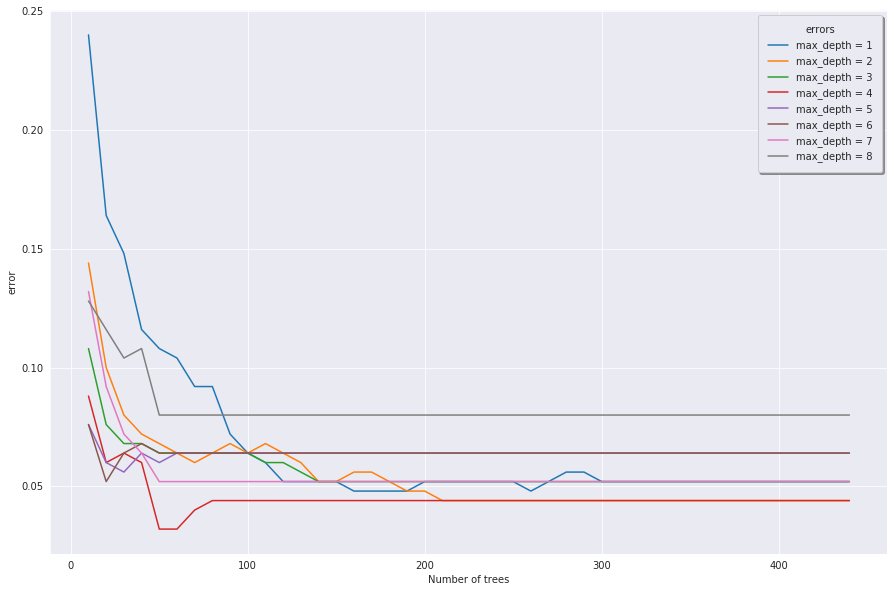

In [272]:
fig = plt.figure(figsize=(15, 10))
for i in range(d_):
    ax = sns.lineplot(estimators, y=errors[i], label=f"max_depth = {i + 1}")

    ax.set_xlabel("Number of trees")
    ax.set_ylabel("error")
    ax.legend(loc="upper right", fancybox=True, framealpha=1, shadow=True, borderpad=1, title="errors")

#### A: Beste Parameter sind: 80 Bäume mit maximaler Tiefe 4, oder auch 220 Bäume mit maximaler Tiefe 2.